# **Analisis Sentimen Pada Tayangan Youtube [Eksklusif] Jurus Bertahan Khofifah - Emil | Mata Najwa**

**Data yang digunakan merupakan komentar dari video YouTube pada tautan berikut: *https://youtu.be/i4Uvxb8D4Sg?si=XwmUXm3C6LwVW_7z*, yang diambil menggunakan YouTube API V3.**

### **DATA PRE PROCESSING**

In [ ]:
# Instal TextBlob
!pip install textblob

# Download resource bahasa untuk TextBlob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
# Import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from IPython.display import display, HTML

In [ ]:
# Unduh Stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Mengunggah file CSV
from google.colab import files
uploaded = files.upload()

Saving datasentimen.csv to datasentimen.csv


In [ ]:
#Membaca dan Menampilkan 10 baris pertama
data = pd.read_csv('datasentimen.csv', delimiter=';')
data.head(10).style

,Name,Comment,Time,Likes,Reply Count,(
0,@Mutiara413,POLITIK BAKAS JASA,2024-09-09T07:52:48Z,0,0,politik bakas jasa
1,@Mutiara413,"DOA A KU UNTUK BU RISMA, MOGA SUKSES ,JADI GUBERNUR",2024-09-09T07:44:24Z,0,0,"doa a ku untuk bu risma, moga sukses ,jadi gubernur"
2,@Anonymous_Jibril,"Bu Risma Good, Pekerja keras, Transparansi, Sungguh2, Peka thd Service Masyarakat, Khofifah Ahli Pidato, kinerja landai2 sja, kerja rutinitas spt makan 3x sehari, demi warga Jatim cukup Risma",2024-09-09T06:16:12Z,0,0,"bu risma good, pekerja keras, transparansi, sungguh2, peka thd service masyarakat, khofifah ahli pidato, kinerja landai2 sja, kerja rutinitas spt makan 3x sehari, demi warga jatim cukup risma"
3,@user-su6di1iy2v,Aku blitar..pilih bu Risma,2024-09-09T03:47:49Z,0,0,aku blitar..pilih bu risma
4,@simonnyetz9493,ASAL BUKAN ANTEK JOKOWI,2024-09-09T02:53:03Z,0,0,asal bukan antek jokowi
5,@krisservice,Preeeeet.....,2024-09-09T00:33:12Z,0,0,preeeeet.....
6,@alexbocah-z9m,Saya orang kalimantan dukung emil dan khofifah,2024-09-08T15:23:29Z,1,0,saya orang kalimantan dukung emil dan khofifah
7,@findanadinesafira9209,Harusnya pasangan yg cocok memimpin jawa timur itu bu Risma dan pak Emil.. Psti jwa timur maju,2024-09-08T14:14:36Z,0,0,harusnya pasangan yg cocok memimpin jawa timur itu bu risma dan pak emil.. psti jwa timur maju
8,@user-gf7fk2zz8n,Asli pendamping gusdur tau sejarah PKB dan ke NU an nya asli banget. Dia di usung karena sosok pribadi tapi yg lain di usung oleh sosok partai.,2024-09-08T14:05:27Z,0,0,asli pendamping gusdur tau sejarah pkb dan ke nu an nya asli banget. dia di usung karena sosok pribadi tapi yg lain di usung oleh sosok partai.
9,@sitiasiyah1859,"Fix, gk akan saya pilih",2024-09-08T12:41:45Z,0,0,"fix, gk akan saya pilih"


In [ ]:
# Menampilkan jumlah baris dan kolom Sebelum Hapus Duplikat
jumlah_baris, jumlah_kolom = data.shape
print(f"Jumlah Baris: {jumlah_baris}")
print(f"Jumlah Kolom: {jumlah_kolom}")

Jumlah Baris: 1748
Jumlah Kolom: 6


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         1748 non-null   object
 1   Comment      1743 non-null   object
 2   Time         1748 non-null   object
 3   Likes        1748 non-null   int64 
 4   Reply Count  1748 non-null   int64 
 5   (            1743 non-null   object
dtypes: int64(2), object(4)
memory usage: 82.1+ KB
None


In [ ]:
# Melihat Missing Values dari Kolom yang ada
print(data.isnull().sum())

Name           0
Comment        5
Time           0
Likes          0
Reply Count    0
(              5
dtype: int64


In [ ]:
# Menampilkan jumlah duplikat
duplicates = data.duplicated()
print(duplicates.sum())

2


**Menghapus Data Duplikat**

In [ ]:
# Menghapus duplikat dari DataFrame
data_deduped = data.drop_duplicates()

# Menampilkan data setelah penghapusan duplikat dalam bentuk tabel
print("Data setelah penghapusan duplikat:")
display(HTML(data_deduped.head(10).to_html()))

Data setelah penghapusan duplikat:


,Name,Comment,Time,Likes,Reply Count,(
0,@Mutiara413,POLITIK BAKAS JASA,2024-09-09T07:52:48Z,0,0,politik bakas jasa
1,@Mutiara413,"DOA A KU UNTUK BU RISMA, MOGA SUKSES ,JADI GUBERNUR",2024-09-09T07:44:24Z,0,0,"doa a ku untuk bu risma, moga sukses ,jadi gubernur"
2,@Anonymous_Jibril,"Bu Risma Good, Pekerja keras, Transparansi, Sungguh2, Peka thd Service Masyarakat, Khofifah Ahli Pidato, kinerja landai2 sja, kerja rutinitas spt makan 3x sehari, demi warga Jatim cukup Risma",2024-09-09T06:16:12Z,0,0,"bu risma good, pekerja keras, transparansi, sungguh2, peka thd service masyarakat, khofifah ahli pidato, kinerja landai2 sja, kerja rutinitas spt makan 3x sehari, demi warga jatim cukup risma"
3,@user-su6di1iy2v,Aku blitar..pilih bu Risma,2024-09-09T03:47:49Z,0,0,aku blitar..pilih bu risma
4,@simonnyetz9493,ASAL BUKAN ANTEK JOKOWI,2024-09-09T02:53:03Z,0,0,asal bukan antek jokowi
5,@krisservice,Preeeeet.....,2024-09-09T00:33:12Z,0,0,preeeeet.....
6,@alexbocah-z9m,Saya orang kalimantan dukung emil dan khofifah,2024-09-08T15:23:29Z,1,0,saya orang kalimantan dukung emil dan khofifah
7,@findanadinesafira9209,Harusnya pasangan yg cocok memimpin jawa timur itu bu Risma dan pak Emil.. Psti jwa timur maju,2024-09-08T14:14:36Z,0,0,harusnya pasangan yg cocok memimpin jawa timur itu bu risma dan pak emil.. psti jwa timur maju
8,@user-gf7fk2zz8n,Asli pendamping gusdur tau sejarah PKB dan ke NU an nya asli banget. Dia di usung karena sosok pribadi tapi yg lain di usung oleh sosok partai.,2024-09-08T14:05:27Z,0,0,asli pendamping gusdur tau sejarah pkb dan ke nu an nya asli banget. dia di usung karena sosok pribadi tapi yg lain di usung oleh sosok partai.
9,@sitiasiyah1859,"Fix, gk akan saya pilih",2024-09-08T12:41:45Z,0,0,"fix, gk akan saya pilih"


In [ ]:
# Menampilkan jumlah baris sebelum dan sesudah penghapusan duplikat
num_rows_before = len(data)
num_rows_after = len(data_deduped)

print(f"Jumlah baris sebelum penghapusan duplikat: {num_rows_before}")
print(f"Jumlah baris setelah penghapusan duplikat: {num_rows_after}")
print(f"Jumlah duplikat yang dihapus: {num_rows_before - num_rows_after}")

Jumlah baris sebelum penghapusan duplikat: 1748
Jumlah baris setelah penghapusan duplikat: 1746
Jumlah duplikat yang dihapus: 2


In [ ]:
print(data.columns)  # Menampilkan semua nama kolom
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)  # Menghapus mention dan hashtag
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    return text

Index(['Name', 'Comment', 'Time', 'Likes', 'Reply Count', '('], dtype='object')


**Membersihkan Komentar**

In [ ]:
# Membaca file CSV yang diunggah
# Specify the delimiter and error handling
data = pd.read_csv('datasentimen.csv', delimiter=';', on_bad_lines='skip')

# Definisikan fungsi untuk membersihkan komentar
def clean_comment(comment):
    # Handle None values
    if comment is None:
        return ''
    # Convert to string
    comment = str(comment)
    # Menghapus hashtag
    comment = re.sub(r'#\w+', '', comment)
    # Mengubah menjadi huruf kecil
    comment = comment.lower()
    # Menghapus URL
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)
    # Menghapus karakter non-alfabet (kecuali spasi)
    comment = re.sub(r'[^a-zA-Z\s]', '', comment)
    # Menghapus kata yang sangat pendek (misalnya, kata dengan panjang kurang dari 3)
    comment = ' '.join(word for word in comment.split() if len(word) > 2)
    return comment

# Check the column names of the DataFrame
print(data.columns)

# Assuming the column with comments is named 'Comment'
if 'Comment' in data.columns:  # Changed 'comment' to 'Comment'
    data['cleaned_comment'] = data['Comment'].apply(clean_comment)  # Changed 'comment' to 'Comment'
else:
    raise ValueError("Kolom 'Comment' tidak ditemukan dalam DataFrame.")  # Changed 'comment' to 'Comment'

# Menampilkan hasil dalam bentuk tabel
print("Data setelah pembersihan komentar:")
display(HTML(data[['Comment', 'cleaned_comment']].head(10).to_html()))  # Changed 'comment' to 'Comment'

Index(['Name', 'Comment', 'Time', 'Likes', 'Reply Count', '('], dtype='object')
Data setelah pembersihan komentar:


,Comment,cleaned_comment
0,POLITIK BAKAS JASA,politik bakas jasa
1,"DOA A KU UNTUK BU RISMA, MOGA SUKSES ,JADI GUBERNUR",doa untuk risma moga sukses jadi gubernur
2,"Bu Risma Good, Pekerja keras, Transparansi, Sungguh2, Peka thd Service Masyarakat, Khofifah Ahli Pidato, kinerja landai2 sja, kerja rutinitas spt makan 3x sehari, demi warga Jatim cukup Risma",risma good pekerja keras transparansi sungguh peka thd service masyarakat khofifah ahli pidato kinerja landai sja kerja rutinitas spt makan sehari demi warga jatim cukup risma
3,Aku blitar..pilih bu Risma,aku blitarpilih risma
4,ASAL BUKAN ANTEK JOKOWI,asal bukan antek jokowi
5,Preeeeet.....,preeeeet
6,Saya orang kalimantan dukung emil dan khofifah,saya orang kalimantan dukung emil dan khofifah
7,Harusnya pasangan yg cocok memimpin jawa timur itu bu Risma dan pak Emil.. Psti jwa timur maju,harusnya pasangan cocok memimpin jawa timur itu risma dan pak emil psti jwa timur maju
8,Asli pendamping gusdur tau sejarah PKB dan ke NU an nya asli banget. Dia di usung karena sosok pribadi tapi yg lain di usung oleh sosok partai.,asli pendamping gusdur tau sejarah pkb dan nya asli banget dia usung karena sosok pribadi tapi lain usung oleh sosok partai
9,"Fix, gk akan saya pilih",fix akan saya pilih


In [ ]:
# Menampilkan hasil dalam bentuk tabel
print("Data setelah pembersihan komentar:")
display(HTML(data[['Comment', 'cleaned_comment']].head(10).to_html()))  # Changed 'comment' to 'Comment'

Data setelah pembersihan komentar:


,Comment,cleaned_comment
0,POLITIK BAKAS JASA,politik bakas jasa
1,"DOA A KU UNTUK BU RISMA, MOGA SUKSES ,JADI GUBERNUR",doa untuk risma moga sukses jadi gubernur
2,"Bu Risma Good, Pekerja keras, Transparansi, Sungguh2, Peka thd Service Masyarakat, Khofifah Ahli Pidato, kinerja landai2 sja, kerja rutinitas spt makan 3x sehari, demi warga Jatim cukup Risma",risma good pekerja keras transparansi sungguh peka thd service masyarakat khofifah ahli pidato kinerja landai sja kerja rutinitas spt makan sehari demi warga jatim cukup risma
3,Aku blitar..pilih bu Risma,aku blitarpilih risma
4,ASAL BUKAN ANTEK JOKOWI,asal bukan antek jokowi
5,Preeeeet.....,preeeeet
6,Saya orang kalimantan dukung emil dan khofifah,saya orang kalimantan dukung emil dan khofifah
7,Harusnya pasangan yg cocok memimpin jawa timur itu bu Risma dan pak Emil.. Psti jwa timur maju,harusnya pasangan cocok memimpin jawa timur itu risma dan pak emil psti jwa timur maju
8,Asli pendamping gusdur tau sejarah PKB dan ke NU an nya asli banget. Dia di usung karena sosok pribadi tapi yg lain di usung oleh sosok partai.,asli pendamping gusdur tau sejarah pkb dan nya asli banget dia usung karena sosok pribadi tapi lain usung oleh sosok partai
9,"Fix, gk akan saya pilih",fix akan saya pilih


### **ANALISIS SENTIMEN**

Analisis Sentimen dengan Model Sederhana

In [ ]:
# Langkah 1: Menambahkan Kolom Sentiment
def classify_sentiment(comment):
    # Aturan sederhana untuk klasifikasi sentimen
    positive_keywords = ['bagus', 'dukung', 'menang', 'maju', 'sukses','pilih']
    negative_keywords = ['tidak', 'kalah', 'ora', 'benci', 'bosan','anti']

    # Konversi komentar ke huruf kecil
    comment = comment.lower()

    # Periksa adanya kata kunci
    if any(keyword in comment for keyword in positive_keywords):
        return 'Positive' # Added indentation
    elif any(keyword in comment for keyword in negative_keywords):
        return 'Negative' # Added indentation

# Terapkan fungsi klasifikasi ke kolom 'cleaned_comment'
data['Sentiment'] = data['cleaned_comment'].apply(classify_sentiment)

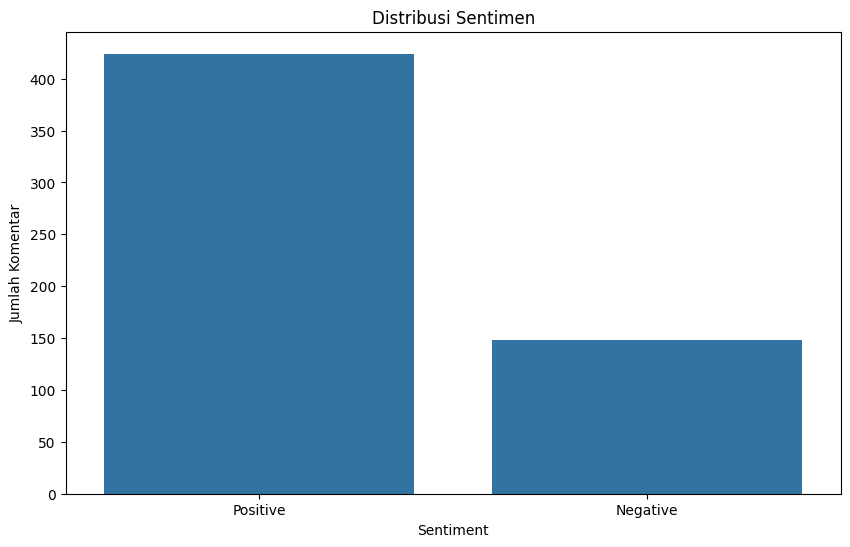

In [ ]:
# Langkah 2: Visualisasi Distribusi Sentimen
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Sentiment')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Komentar')
plt.show()

Analisis Sentimen dengan Model Vader

In [ ]:
# Sentiment Analysis dengan VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    return 'positive' if score >= 0 else 'negative'

data['sentiment'] = data['cleaned_comment'].apply(get_sentiment)
data_filtered = data[data['sentiment'].isin(['positive', 'negative'])]

In [ ]:
# Menampilkan hasil analisis sentimen
display(data_filtered[['Comment', 'cleaned_comment', 'sentiment']].head(10))

,Comment,cleaned_comment,sentiment
0,POLITIK BAKAS JASA,politik bakas jasa,positive
1,"DOA A KU UNTUK BU RISMA, MOGA SUKSES ,JADI GUB...",doa untuk risma moga sukses jadi gubernur,negative
2,"Bu Risma Good, Pekerja keras, Transparansi, Su...",risma good pekerja keras transparansi sungguh ...,positive
3,Aku blitar..pilih bu Risma,aku blitarpilih risma,positive
4,ASAL BUKAN ANTEK JOKOWI,asal bukan antek jokowi,positive
5,Preeeeet.....,preeeeet,positive
6,Saya orang kalimantan dukung emil dan khofifah,saya orang kalimantan dukung emil dan khofifah,positive
7,Harusnya pasangan yg cocok memimpin jawa timur...,harusnya pasangan cocok memimpin jawa timur it...,positive
8,Asli pendamping gusdur tau sejarah PKB dan ke ...,asli pendamping gusdur tau sejarah pkb dan nya...,positive
9,"Fix, gk akan saya pilih",fix akan saya pilih,positive


In [ ]:
# Ekstraksi fitur dengan TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data_filtered['cleaned_comment'])
y = data_filtered['sentiment']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Logistic Regression
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Prediksi dan Evaluasi Model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9914285714285714
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
    positive       0.99      1.00      1.00       347

    accuracy                           0.99       350
   macro avg       0.50      0.50      0.50       350
weighted avg       0.98      0.99      0.99       350



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


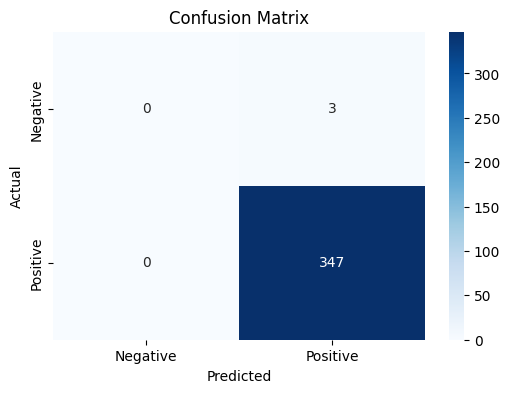

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

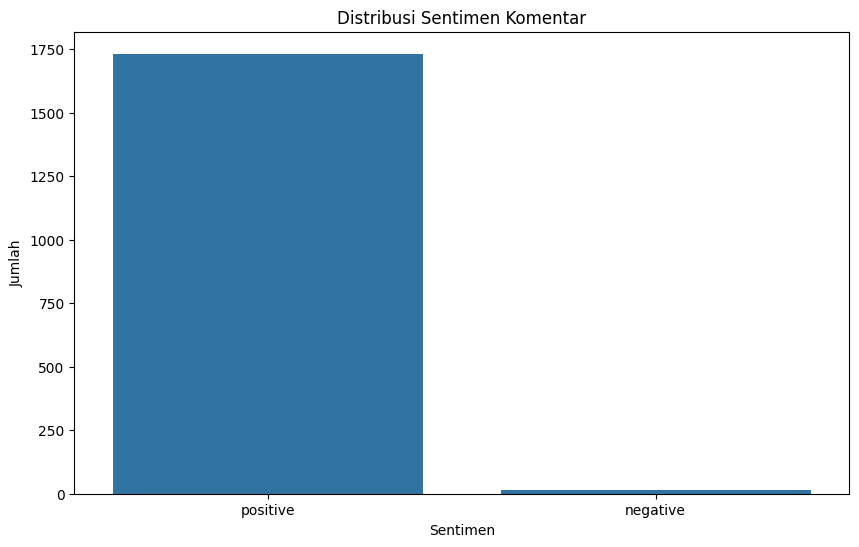

In [ ]:
# Visualisasi distribusi sentimen (setelah penyaringan)
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=data_filtered)
plt.title('Distribusi Sentimen Komentar')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

### **KESIMPULAN**

Berdasarkan hasil analisis sentimen yang telah dilakukan menggunakan dua pendekatan, yaitu model sederhana berbasis keyword dan model VADER, berikut adalah kesimpulan lengkap:

1. Model Sederhana Berbasis Keyword

Grafik distribusi sentimen menunjukkan bahwa:
a. Sentimen Positif Mendominasi: Lebih dari 400 komentar dikategorikan sebagai sentimen positif; komentar negatif hanya sekitar 150, menunjukkan bahwa jumlah komentar negatif lebih sedikit daripada positif.
b. Model sederhana ini bekerja dengan mencocokkan kata-kata tertentu, seperti ('bagus', 'dukung', 'menang', 'maju', 'sukses','pilih') untuk kata kunci kalimat positif, dan ('tidak', 'kalah', 'ora', 'benci', 'bosan','anti') untuk kata kunci kalimat negatif. Akibatnya, hasilnya sangat bergantung pada cakupan kata kunci yang dipilih.
2. Model VADER (Valence Aware Dictionary and sEntiment Reasoner)

Hasil dari model VADER menunjukkan hasil yang cukup berbeda:
a. Sentimen Positif Jauh Lebih Dominan: Model ini menganggap sebagian besar teks memiliki sentimen positif, seperti yang ditunjukkan oleh hampir 1.750 komentar positif.
b. Sentimen Negatif Sangat Sedikit: Ada hanya lima puluh komentar negatif. Ini menunjukkan bahwa model VADER mungkin lebih toleran terhadap ekspresi yang ambigu atau netral, yang membuatnya sentimen positif.


---


Perbandingan Kedua Model:

Jumlah Sentimen Positif pada model sederhana terdapat lebih banyak komentar negatif (sekitar 150), tetapi pada model VADER hanya ada sedikit sentimen negatif. Hasil menunjukkan bahwa komentar dengan sentimen positif sangat dominan dalam kedua model, meskipun jumlahnya lebih besar dalam model VADER.
Kedua model ini berbeda dalam sensitivitas mereka terhadap pola bahasa. Model sederhana berbasis keyword terlalu bergantung pada kata-kata yang telah didefinisikan sebelumnya, sehingga tidak dapat mengidentifikasi perubahan yang mungkin menunjukkan sentimen tertentu. Namun, model VADER lebih luas karena dapat memahami lebih banyak aspek emosi, meskipun tampaknya lebih cenderung mengkategorikan teks sebagai positif.



---


**Kesimpulan Akhir Analisis Sentimen**

Dari kedua pendekatan, jelas bahwa sebagian besar komentar cenderung positif; ini menunjukkan bahwa persepsi keseluruhan topik yang dianalisis sangat baik. Ada sedikit komentar negatif di kedua model, tetapi di model VADER ada lebih sedikit. Model VADER yang lebih berfokus pada konteks emosional secara keseluruhan daripada pencocokan kata kunci mungkin penyebabnya.

